## Introduction
####  Identify the type of climate the exoplanet has based on the properties of the fruit. 

### Import the necessary packages.

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
import re
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Import train and test dataset

In [32]:
train=pd.read_csv("/content/gdrive/MyDrive/odetocode_predicting_weather_using_alien_fruit_propertie/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/odetocode_predicting_weather_using_alien_fruit_propertie/test.csv")

#### The columns name contains hyphen(-).Let's replace it with an underscore(_). Also, change the categorical levels are recorded by using the competition data dictionary.

In [34]:
def clean(df):

  df=df.rename(columns={col:re.sub("\-","_",col) for col in df.columns.values})

  
  edible_map={'e':'edible', 'p':'poisonous'}

  cap_shape_map={'b':'bell', 'c':'conical', 'x':'convex', 'f':'flat',
                's':'sunken', 'p':'spherical', 'o':'others'}

  cap_clr_map={'n':'brown', 'b':'buff', 'g':'gray', 
              'r':'green', 'p':'pink', 'u':'purple',
              'e':'red', 'w':'white', 'y':'yellow',
              'l':'blue', 'o':'orange', 'k':'black'}

  dbd_map={'t':'bruises_or_bleeding','f':'no'}   

  gill_att_map={'a':'adnate', 'x':'adnexed', 'd':'decurrent', 'e':'free', 
                's':'sinuate', 'p':'pores', 'f':'none'} 

  gill_clr_map={**cap_clr_map,**dict(f='none')}     

  stem_clr_map=gill_clr_map

  has_ring_map={'t':'ring', 'f':'none'}

  ring_type_map=dict(c='cobwebby', e='evanescent', r='flaring',
                    g='grooved', l='large', p='pendant', 
                    s='sheathing', z='zone', y='scaly', 
                    m='movable', f='none')


  habitat_map=dict(g='grasses', l='leaves', m='meadows',
                  p='paths', h='heaths', u='urban', 
                  w='waste', d='woods')
  
  map_columns=[edible_map,cap_shape_map,cap_clr_map,dbd_map,gill_att_map,gill_clr_map,
               stem_clr_map,has_ring_map,ring_type_map,habitat_map]
  
  def cat_level_map(df):
    for i, (col,maps) in enumerate(zip(['edible_poisonous', 'cap_shape', 'cap_color',
                                        'does_bruise_or_bleed','gill_attachment', 
                                        'gill_color', 'stem_color', 'has_ring', 
                                        'ring_type','habitat'],map_columns)):
      df[col]=df[col].map(maps)
    return df  


  df= cat_level_map(df)

  return df           


### Feature Engineering

In [35]:
def pre_process(df):
  """initialize the imputer"""
  cat_enc=SimpleImputer(strategy='most_frequent')

  """creating a missing value indicator for column """
  def miss_indicator(df):
    for col in df.columns[df.isnull().any()].values:
      df[col+'_null']=(df[col].isnull()).astype('int') 
    return df

  df=miss_indicator(df)
  
  """ fill the categorical missing values"""
  df['gill_attachment']=cat_enc.fit_transform(df[['gill_attachment']])
  df['ring_type']=cat_enc.fit_transform(df[['ring_type']])

  """convert the mm to cm """
  df['stem_width']=df['stem_width']/10
  df['height_width_ratio']=df['stem_height']/df['stem_width']
  df['cd_hi_ratio']=df['stem_height']/df['cap_diameter']
  df['cd_wi_ratio']=df['stem_width']/df['cap_diameter']


  """categorical columns list"""
  grpcol=['edible_poisonous', 'cap_shape', 'cap_color',
          'does_bruise_or_bleed', 'gill_attachment', 'gill_color',
          'stem_color','has_ring', 'ring_type', 'habitat',
          ]

  """numerical columns list"""
  numcols=['cap_diameter', 'stem_height', 'stem_width','height_width_ratio','cd_hi_ratio','cd_wi_ratio']


  """group by numerical summary of each numerical column"""
  def feature_eng(df):
    for valcol in numcols:
      df1=(df.groupby(grpcol)[valcol].
             agg({'min','median','max',np.ptp}).reset_index())
      df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|max|ptp)")]}))
      df=pd.merge(df,df1,on=grpcol,how='left')
    return df  


  df=feature_eng(df)


  def count_feat(df):
    for col in grpcol:
      df[f"{col}_count"]=train.groupby([col])[col].transform('count')
    return df


  df=count_feat(df)


  return df

### Create dummy variables for categorical columns.

In [23]:
def dummies(df):
  dummy=pd.get_dummies(df.loc[:,['edible_poisonous', 'cap_shape', 'cap_color',
       'does_bruise_or_bleed', 'gill_attachment', 'gill_color',
       'stem_color', 'has_ring', 'ring_type', 'habitat']])
  df=df.drop(columns=['edible_poisonous', 'cap_shape', 'cap_color',
       'does_bruise_or_bleed', 'gill_attachment', 'gill_color',
       'stem_color', 'has_ring', 'ring_type', 'habitat'])
  df=pd.concat([df,dummy],axis=1)
  return df

### Apply the cleaning step to train data.

In [36]:
train=clean(train)
train=pre_process(train)
#train=dummies(train)

### Apply the cleaning step to test data.

In [37]:
test=clean(test)
test=pre_process(test)
#test=dummies(test)

### Let's create a catboost classifier model with optuna hyperparemeter optimization.

In [ ]:
!pip install optuna
!pip install catboost

### Import Necessary Packages

In [38]:
from sklearn.model_selection import  cross_val_score,KFold,train_test_split,ShuffleSplit,StratifiedKFold,learning_curve,RandomizedSearchCV
from catboost import CatBoostClassifier,Pool,cv,monoforest
import optuna
from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss,accuracy_score
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback,LightGBMPruningCallback
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures
import lightgbm as lgbm
import math

### Split predictor and target variables.

In [66]:
for i,col in enumerate(train.columns):
  print(f"{i}_{col}")

0_edible_poisonous
1_cap_diameter
2_cap_shape
3_cap_color
4_does_bruise_or_bleed
5_gill_attachment
6_gill_color
7_stem_height
8_stem_width
9_stem_color
10_has_ring
11_ring_type
12_habitat
13_season
14_gill_attachment_null
15_ring_type_null
16_height_width_ratio
17_cd_hi_ratio
18_cd_wi_ratio
19_cap_diameter_median
20_cap_diameter_ptp
21_cap_diameter_min
22_cap_diameter_max
23_stem_height_median
24_stem_height_ptp
25_stem_height_min
26_stem_height_max
27_stem_width_median
28_stem_width_ptp
29_stem_width_min
30_stem_width_max
31_height_width_ratio_median
32_height_width_ratio_ptp
33_height_width_ratio_min
34_height_width_ratio_max
35_cd_hi_ratio_median
36_cd_hi_ratio_ptp
37_cd_hi_ratio_min
38_cd_hi_ratio_max
39_cd_wi_ratio_median
40_cd_wi_ratio_ptp
41_cd_wi_ratio_min
42_cd_wi_ratio_max
43_edible_poisonous_count
44_cap_shape_count
45_cap_color_count
46_does_bruise_or_bleed_count
47_gill_attachment_count
48_gill_color_count
49_stem_color_count
50_has_ring_count
51_ring_type_count
52_habitat

### Convert the target levels to number by using label encoder.

In [39]:
target_lbl=LabelEncoder()

In [40]:
train['season']=target_lbl.fit_transform(train['season'])

In [41]:
train.fillna(0,inplace=True)

In [42]:
X=train.iloc[:,np.r_[0:13,14:53]]
y=train['season']

In [84]:
train.select_dtypes(include="object").columns

Index(['edible_poisonous', 'cap_shape', 'cap_color', 'does_bruise_or_bleed',
       'gill_attachment', 'gill_color', 'stem_color', 'has_ring', 'ring_type',
       'habitat'],
      dtype='object')

In [83]:
train.columns[train.isnull().any()]

Index([], dtype='object')

### Define the catboost model

In [43]:
def objective(trial):
  skf = StratifiedKFold(n_splits=10,random_state=2000,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param = {
  
        'reg_lambda':trial.suggest_int('reg_lambda',10,1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators',50,1000),
        'max_depth': trial.suggest_int('max_depth', 2,12),
        #'random_strength' :trial.suggest_float('random_strength', 0.1,1.0),      
        #'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        #max_ctr_complexity':trial.suggest_categorical('max_ctr_complexity',[1,2,3,4,5]),
        'random_state': trial.suggest_categorical('random_state', [1024, 1048,2020]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01,1.0),
        "boosting_type": trial.suggest_categorical("boosting_type", [#"Ordered", 
                                                                     "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian",
                                                                    "Bernoulli", #"MVS"
                                                                    ]
        ),
        }
  if param["bootstrap_type"] == "Bayesian":
    param["bagging_temperature"] = trial.suggest_float('bagging_temperature', 1,20)
  elif param["bootstrap_type"] == "Bernoulli":
    param["subsample"] = trial.suggest_float("subsample", 0.1, 1.0)
  
  cat_clf = CatBoostClassifier(eval_metric="Accuracy",task_type='GPU',   grow_policy = 'Lossguide',
                               logging_level="Silent",
                              **param)
  cat_clf.fit(X_train, y_train,early_stopping_rounds=50,
              eval_set=(X_valid, y_valid),
              cat_features=['edible_poisonous', 'cap_shape', 'cap_color',
                                              'does_bruise_or_bleed','gill_attachment',
                                              'gill_color', 'stem_color',
                                              'has_ring', 'ring_type','habitat']
  )
  preds = cat_clf.predict(X_valid)
  accuracy = accuracy_score(y_valid, preds)
  return accuracy
  


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize',sampler=TPESampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

[I 2022-02-16 15:56:56,532] A new study created in memory with name: no-name-43d5557e-e746-41b5-8acc-02f6bd753db2
[I 2022-02-16 15:56:59,861] Trial 0 finished with value: 0.4988301357042583 and parameters: {'reg_lambda': 751, 'learning_rate': 0.009045384898792766, 'n_estimators': 925, 'max_depth': 5, 'random_state': 1024, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 19.989163932718412}. Best is trial 0 with value: 0.4988301357042583.
[I 2022-02-16 15:57:02,974] Trial 1 finished with value: 0.5042115114646701 and parameters: {'reg_lambda': 642, 'learning_rate': 0.043764509904281476, 'n_estimators': 633, 'max_depth': 5, 'random_state': 1024, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.326769529520804}. Best is trial 1 with value: 0.5042115114646701.
[I 2022-02-16 15:57:08,182] Trial 2 finished with value: 0.5011698642957417 and parameters: {'reg_lambda': 615, 'learning_rate': 0.029106296341438815, 'n_estimators': 357,

Number of finished trials: 100
Best trial: {'reg_lambda': 297, 'learning_rate': 0.05388146941119505, 'n_estimators': 615, 'max_depth': 9, 'random_state': 1024, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5684070679658948}


In [44]:
study.best_value

0.5360318203088442

In [45]:
study.best_params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'learning_rate': 0.05388146941119505,
 'max_depth': 9,
 'n_estimators': 615,
 'random_state': 1024,
 'reg_lambda': 297,
 'subsample': 0.5684070679658948}

### Visualizing the Optimization History - Explains the best score at each trails.

In [46]:
optuna.visualization.plot_optimization_history(study)

### Visualizing High-dimensional Parameter Relationships

In [47]:
optuna.visualization.plot_slice(study)

### Visualizing Parameter Importances

In [48]:
optuna.visualization.plot_param_importances(study)

### Creat model with tuned parameters

In [49]:
cat_clf = CatBoostClassifier(eval_metric="Accuracy",task_type='GPU',   grow_policy = 'Lossguide',
                              **study.best_params)

### Fit the model

In [ ]:
cat_clf.fit(X,y,cat_features=['edible_poisonous', 'cap_shape', 'cap_color',
                                              'does_bruise_or_bleed','gill_attachment',
                                              'gill_color', 'stem_color',
                                              'has_ring', 'ring_type','habitat'])

### Import shap for model explaination

In [ ]:
!pip install -q shap

In [51]:
import shap

In [52]:
explainer = shap.TreeExplainer(cat_clf)
shap_values = explainer.shap_values(Pool(X, y, cat_features=['edible_poisonous', 'cap_shape', 'cap_color',
                                              'does_bruise_or_bleed','gill_attachment',
                                              'gill_color', 'stem_color',
                                              'has_ring', 'ring_type','habitat']))

### Feature importance plot.

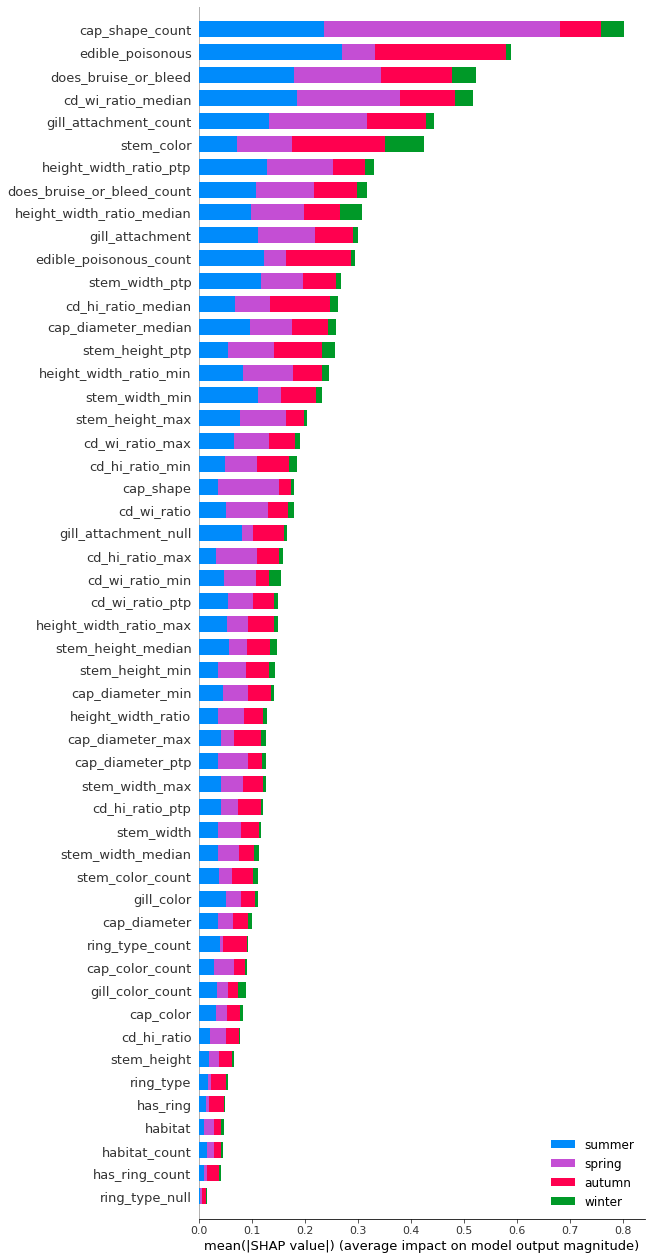

In [53]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=60,class_names=['autumn','spring','summer','winter'])

### Top features impact the model


For autumn_0



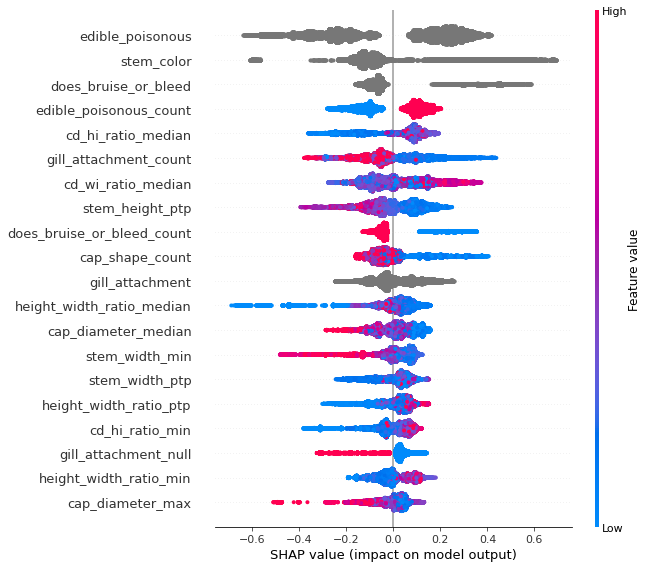


For spring_1



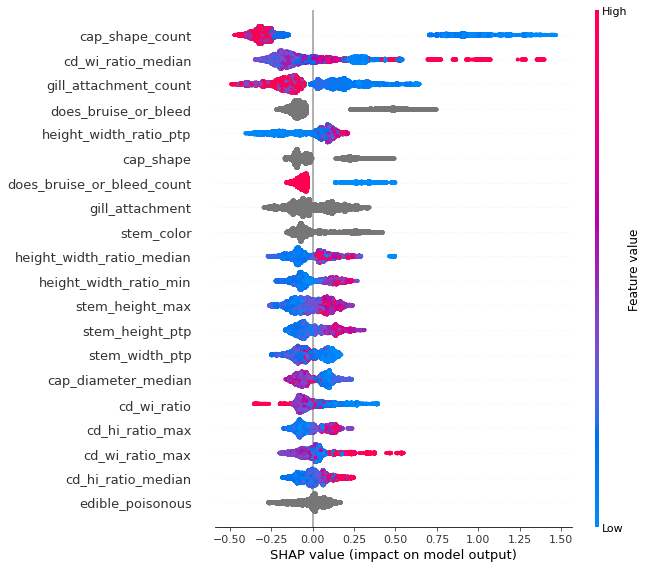


For summer_2



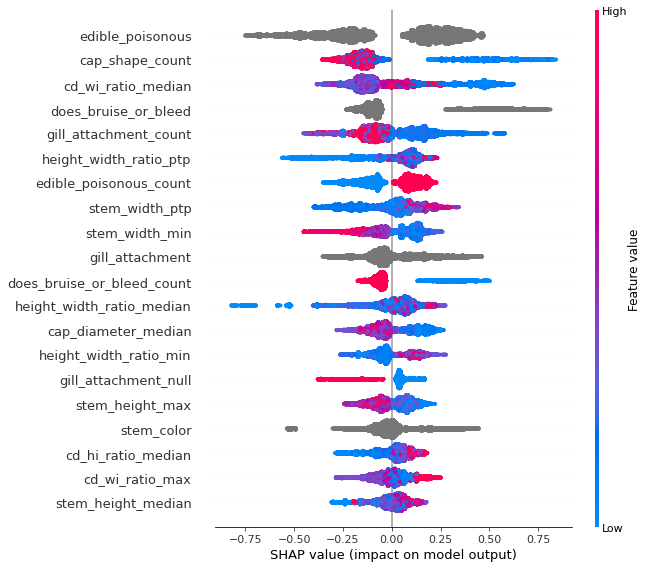


For winter_3



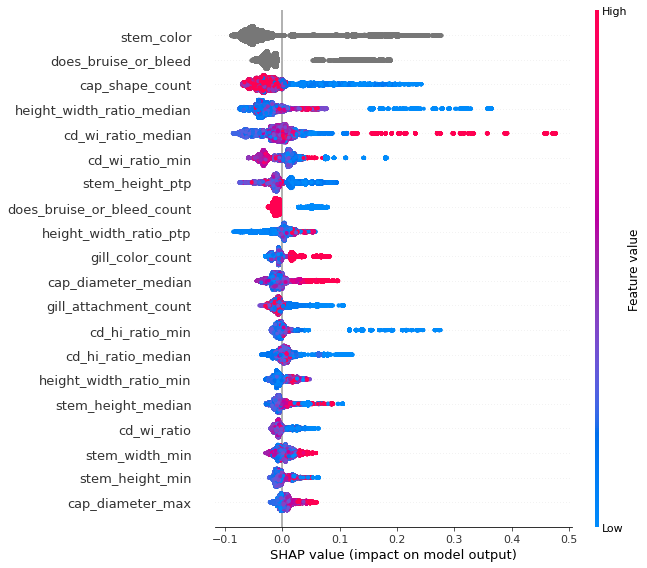

In [54]:
for i,col in enumerate(['autumn','spring','summer','winter']):
  print(f"\nFor {col}_{i}\n")
  shap.summary_plot(shap_values[i], X.values, feature_names = X.columns)

### Let's see which feature influences the model prediction for a single observation in each class. 


For autumn_0



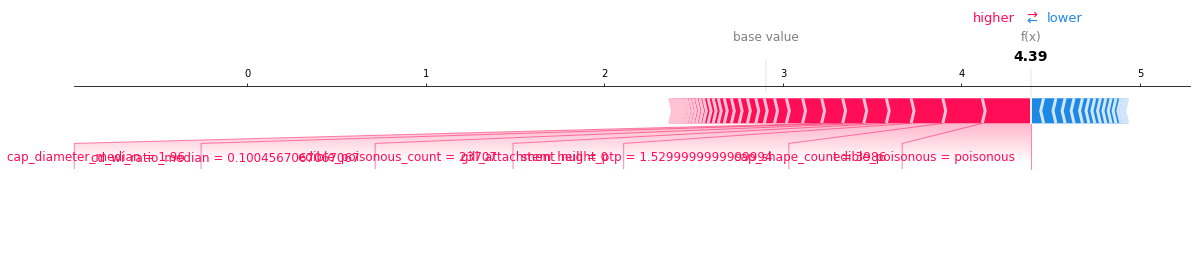


For spring_1



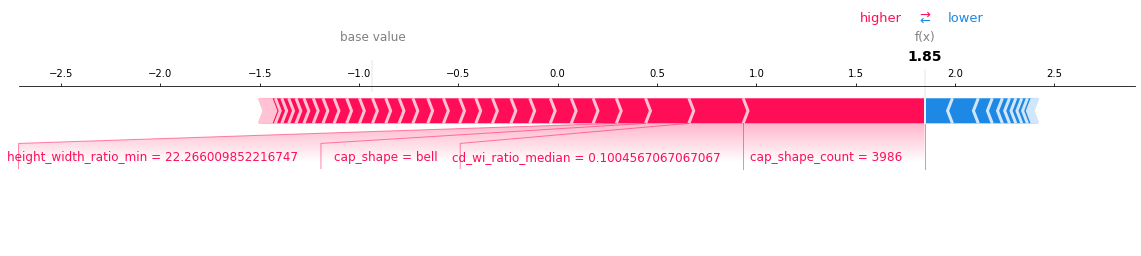


For summer_2



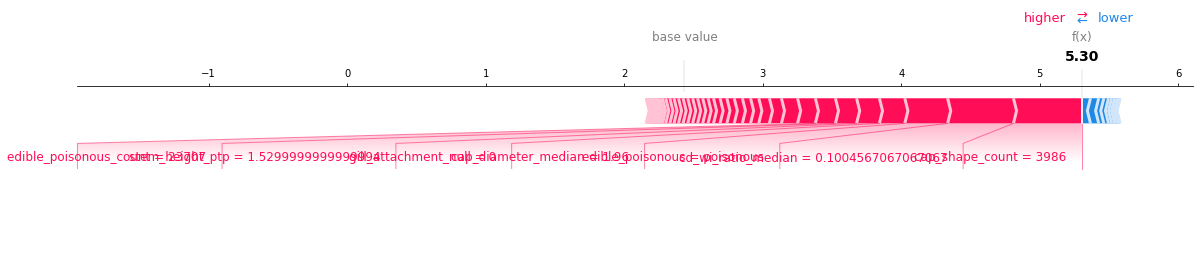


For winter_3



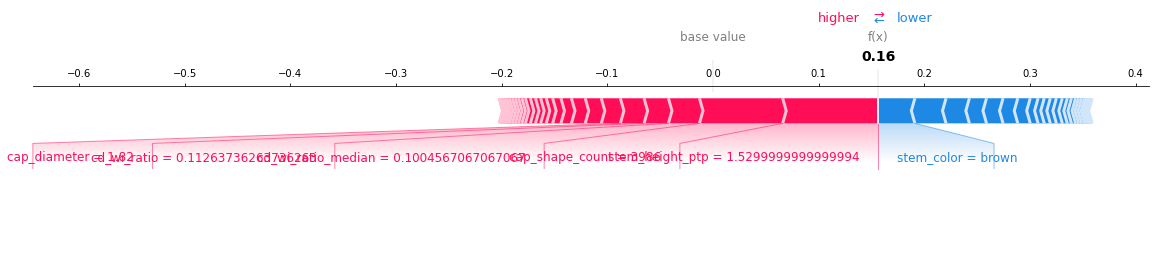

In [55]:
for i,col in enumerate(['autumn','spring','summer','winter']):
  row=8
  print(f"\nFor {col}_{i}\n")
  shap.force_plot(explainer.expected_value[i], shap_values[i][row], X.values[row],
                feature_names = X.columns,matplotlib=True)

### Predict the test data

In [56]:
pred=cat_clf.predict(test.loc[:,X.columns.values])

### Inverse transform the prediction using the previously defined target_lbl encoder.

In [57]:
pred=target_lbl.inverse_transform(pred)

In [58]:
pred

array(['a', 'a', 'u', ..., 'a', 'a', 'u'], dtype=object)

###Write dataframe to csv

In [59]:
res=pd.DataFrame({'season':pred})

In [60]:
res.to_csv("Catboost_classifier_with_optuna_tuning.csv",index=False)